In [44]:
###############################################################################################################################################################
#----------------------------------------------------------------------SETUP-----------------------------------------------------------------------------------
###############################################################################################################################################################

In [45]:
#Imports
#PySpark data handeling imports
from pyspark.sql import SparkSession, Row #Data handeling and preprocessing
from pyspark.sql.functions import regexp_replace, when, col #Data prepocessing
from pyspark.sql import functions as F
from pyspark.ml.image import ImageSchema

#Tensorflow model imports
import tensorflow as tf #TensorFlow
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping #Model optimisation

#SKLearn data handeling imports
from sklearn.model_selection import train_test_split #dataset splitting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #Model evaluations

#Data Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt #graphing

import sys
import numpy as np
import os
from glob import glob
from PIL import Image
import random

In [ ]:
#Enviomental variables

#Solves the following envioment error:
#   "Python in worker has different version 3.10 than that in driver 3.11, PySpark cannot run with different minor versions. 
#       Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set."
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [66]:
#Create new spark session
spark = SparkSession.builder.appName("ImageProcessing").getOrCreate()

In [47]:
###############################################################################################################################################################
#----------------------------------------------------------------------DATA LOADING & PREPROCESSING------------------------------------------------------------
###############################################################################################################################################################

In [48]:
#Get image attributes from CSV using spark
labels_df = spark.read.csv("list_attr_celeba.csv", header=True, inferSchema=True)
labels_df = labels_df.select("image_id", "Male", "Smiling")
labels_df = labels_df.withColumn("image_id", regexp_replace("image_id", ".jpg", ""))

#Normalise smiling label to be binery and not -1 and 1
smiling_norm = when(col("Smiling") >= 0, 1).otherwise(0)
labels_df = labels_df.withColumn("Smiling", smiling_norm)

#Check
labels_df.printSchema()
labels_df.show(5)

root
 |-- image_id: string (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Smiling: integer (nullable = false)

+--------+----+-------+
|image_id|Male|Smiling|
+--------+----+-------+
|  000001|  -1|      1|
|  000002|  -1|      1|
|  000003|   1|      0|
|  000004|  -1|      0|
|  000005|  -1|      0|
+--------+----+-------+
only showing top 5 rows



In [49]:
#Get image file paths
image_dir = "images"
image_files = [(filename.split('.')[0], os.path.join(image_dir, filename)) for filename in os.listdir(image_dir) if filename.endswith('.jpg')]

#Get only a certain number to reduce computational cost and time
image_files = image_files[:10000]

#Convert list to spark dataframe
images_df = spark.createDataFrame([Row(image_id=img[0], image_path=img[1]) for img in image_files])

#Check
images_df.printSchema()
images_df.show(5)

root
 |-- image_id: string (nullable = true)
 |-- image_path: string (nullable = true)

+--------+-----------------+
|image_id|       image_path|
+--------+-----------------+
|  000001|images\000001.jpg|
|  000002|images\000002.jpg|
|  000003|images\000003.jpg|
|  000004|images\000004.jpg|
|  000005|images\000005.jpg|
+--------+-----------------+
only showing top 5 rows



In [ ]:
#Merge image paths with their corresponding class labels
#Creates a new spark dataframe with the image_path and its class label
#Also drops nulls to clean the data and shows the 5 first rows to check the results
labeled_images_df = images_df.join(labels_df, on="image_id")
labeled_images_df = labeled_images_df.select("image_path", "Smiling")
labeled_images_df = labeled_images_df.dropna()
labeled_images_df.show(5)

+-----------------+-------+
|       image_path|Smiling|
+-----------------+-------+
|images\000001.jpg|      1|
|images\000002.jpg|      1|
|images\000003.jpg|      0|
|images\000004.jpg|      0|
|images\000005.jpg|      0|
+-----------------+-------+
only showing top 5 rows



In [51]:
###############################################################################################################################################################
#----------------------------------------------------------------------EXPLORATORY DATA ANALYSIS---------------------------------------------------------------
###############################################################################################################################################################

In [52]:
#Create copy of the dataframe using pandas 
#Pandas is used for easier interaction and graphing
labeled_images_pd = labeled_images_df.toPandas()

Not Smiling & Smiling counts:
Smiling
0    5178
1    4822
Name: count, dtype: int64


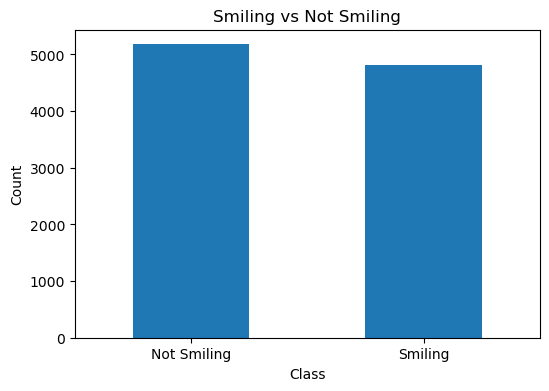

In [53]:
#Output class label data distribution
smiling_counts = labeled_images_pd['Smiling'].value_counts()
print(f"Not Smiling & Smiling counts:\n{smiling_counts}")

plt.figure(figsize=(6, 4))
smiling_counts.plot(kind='bar', title="Smiling vs Not Smiling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Smiling', 'Smiling'], rotation=0)
plt.show()

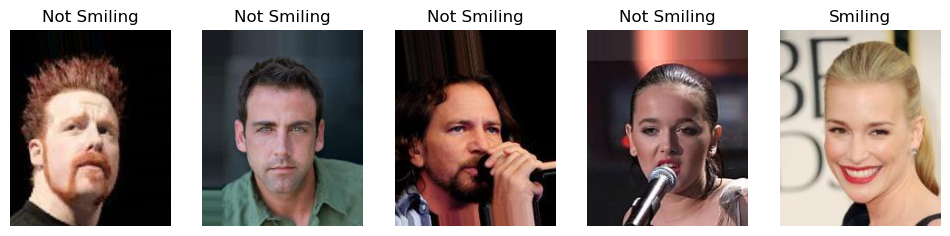

In [54]:
#Show random images with their labels
sample_images = random.sample(list(labeled_images_pd[['image_path', 'Smiling']].values), 5)

plt.figure(figsize=(12, 6))

for i, (img_path, classlabel) in enumerate(sample_images):
    if classlabel == 0:
        label = 'Not Smiling'
    else:
        label = 'Smiling'

    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}")
    plt.axis('off')

plt.show()

In [55]:
###############################################################################################################################################################
#----------------------------------------------------------------------CREATING THE PIPELINES------------------------------------------------------------------
###############################################################################################################################################################

In [56]:
#Data processing functions
#These functions work together inorder to load the images and their paired labels.
#Flow of the data processing for the model training pipeline:
#   the create_tf_datasets() function is called
#   create_tf_datasets() splits the data into training, validation and testing
#   create_tf_datasets() creates the training data but calling the data_generator() function
#       This is done is batches, determined by the .prefetch(tf.data.AUTOTUNE) paramiter, to prevent high memory usage
#   data_generator() takes every image_path and label combination and passes them to load_and_preprocess_image()
#   load_and_preprocess_image() then loads and proprocesses the image, it then returns the image file and label to data_generator()
#   data_generator() returns the list of the images and their labels
#   create_tf_datasets() repeats this process until all the images for each dataset has been loaded
#   create_tf_datasets() then returns each dataset

#Function to load and preprocess images
#This is used to get every image file and its correct label
def load_and_preprocess_image(file_path, label):
    img = tf.io.read_file(file_path) #Load the image in the file path, loads as bytes not a file
    img = tf.io.decode_jpeg(img, channels=3) #Decodes the bytes back into the image
    img = tf.image.resize(img, [128, 128]) #Resizes the image
    img = img / 255.0 #Normalised the scale of the pixels to 0 and 1 instead of 0 and 255
    return img, label #Returns the image and corresponding label

#Function to load the image paths and labels in batches rather than all at once
#Formats the data in a manner that makes the first feature act as an X/input and the second feature be the Y/output
def data_generator(data):
    #Retreives the image files and the labels from the load_and_preprocess_image function
    for image_path, label in data:
        yield load_and_preprocess_image(image_path, label)

#Function to create the three datasets in TensorFlow datasets
#Uses the data_generator function as a python generator inorder to retreive the data in batches
#Training and validation are used while the model is training and testing is used as the new out-of-sample unseen data
def create_tf_datasets(data, test_size=0.3, val_size=0.2, random_state=42, batch_size=64):
    
    #Split the data into train, validation and test sets
    #This is done differently than usual as I wanted to see what would happen if I tried to apply the theory learnt in DANA8412
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state) 
    val_data, test_data = train_test_split(test_data, test_size=val_size, random_state=random_state)

    #Training dataset
    train_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train_data), #Gets every image and label pair
        output_signature=( #Specifies the expected output
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32), #The shape and the type of the images
            tf.TensorSpec(shape=(), dtype=tf.int32) #The type of the labels
        )
        #Shuffle shuffles the dataset in 1000 increments
        #Batch specifies how many entries in every batch
        #Prefetch tells TensorFlow to load the entries in the background in groups, the size is automatically calculated
    ).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE) 

    #Validation dataset
    #The code works the same as above
    val_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(val_data),
        output_signature=(
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
        #As the data size is smaller prefetch and shuffle are not needed
    ).batch(batch_size)

    #Testing dataset
    #The code works the same as above
    test_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(test_data),
        output_signature=(
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
        #As the data size is smaller prefetch and shuffle are not needed
    ).batch(batch_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
#Model functions
#These functions work together inorder to create a model, compile it, train it, then evalauate it
#Flow for the model training pipeline:
#   The pipeline calles the train_model() function and passes it the model type and the required data
#   train_model() creates the correct model using the model types create model function
#   The create model functions declare the CNN model, compliles it, then returns the compiled model
#   train_model() declares the callbacks then fits the model whilst saving the models training history
#   train_model() then returns the trained model and its training history to the pipeline
#   The pipeline then calls evaluate_model() and passes it the model, testing dataset and the models history
#   evaluate_model() then prints the models training evaluations, its testing evaluations and evaluation graphs
#       The training evaluations include the modls final training and validation scores 
#       The testing evaluations are the loss and accuracy scores of the model using the testing dataset
#       The evaluation graphs include the models training loss and accuracy curves and a confusion matrix of the testing data

#Function to return a basic CNN model with few neurons and layers
#This creates a very basic model with two convolutional layers and pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_basic_cnn_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a basic CNN model
#This creates a simple model with three convolutional layers and pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_simple_cnn_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with L2 regularization
#This creates a simple model with three convolutional layers and pooling layers, one fully connected layer and one output layer
#Every convolutional layer and the fully connected layer have L2 regularisation to prevent overfitting
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_simple_cnn_model_with_regularisation():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.003)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.003)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.003)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.003)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with L2 regularization
#This creates a more compelx model with three convolutional layers and pooling layers, two fully connected layers and one output layer
#Every convolutional layer and the two fully connected layers have L2 regularisation to prevent overfitting
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_duel_layered_cnn_model_with_regularisation():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.003)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.003)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.003)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.003)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.003)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to train the model
#The model type is received, the model created, given callbacks, fitted to the data and then returned
def train_model(model_type, train_dataset, val_dataset, epochs=20):
    #Callback functions to prevent overfitting and encorage better convergence
    #A more in-depth explanation of why these approachs were chosen can be found in the accompanying PDF document
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    #Create the model
    model = model_type()

    #The model is then fitted to train
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[lr_scheduler, early_stopping])
    return model, history

#Function to evaluate the model
#Creates evaluations scores and graphs to easily interprete the models performance and generalisation ability
def evaluate_model(model, test_dataset, history):

    #get metrics using the trained model on the unseen out-of-sample testing dataset
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose = 0)

    #Print last results
    print(f"Final Training Loss: {history.history['loss'][-1]}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    #Create a confusion matrix for the model using the testing dataset
    y_true = []
    y_pred = []
    for images, labels in test_dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((preds > 0.5).astype(int).flatten())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=['Not Smiling', 'Smiling'], yticklabels=['Not Smiling', 'Smiling'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    #Plot training accuracy and loss curves for the taining and validation datasets
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
#Pipeline
#This function is the programs pipeline as it takes in the data and what model to use, then automatically processes the data, 
#   fits the data to the model, trains the model, then evaluates the model
def model_pipeline(data, model_type):
    
    #Load and process the data
    #Loads images, assigned labels, and creates TensorFlow datasets with batches
    train_dataset, val_dataset, test_dataset = create_tf_datasets(data=data)

    #Fit the model
    #Creates the model, trains it, ten returns the model and its training history
    model, history = train_model(model_type, train_dataset, val_dataset, epochs=20)

    #Evaluate the model
    #Prints multiple evaluation scores and graphs
    evaluate_model(model, test_dataset, history)

In [ ]:
###############################################################################################################################################################
#----------------------------------------------------------------------APPLYING THE PIPELINES------------------------------------------------------------------
###############################################################################################################################################################

Epoch 1/20
    110/Unknown 23s 180ms/step - accuracy: 0.6272 - loss: 0.6981

c:\Users\cybrm\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.6280 - loss: 0.6968 - val_accuracy: 0.8462 - val_loss: 0.3543 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.8536 - loss: 0.3488 - val_accuracy: 0.8637 - val_loss: 0.3162 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 214ms/step - accuracy: 0.8905 - loss: 0.2680 - val_accuracy: 0.8700 - val_loss: 0.2895 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.9051 - loss: 0.2339 - val_accuracy: 0.8758 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.9140 - loss: 0.2076 - val_accuracy: 0.8667 - val_loss: 0.3073 - learning_rate: 0.0010
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9207 - loss: 0.1784
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.9208 - loss: 0

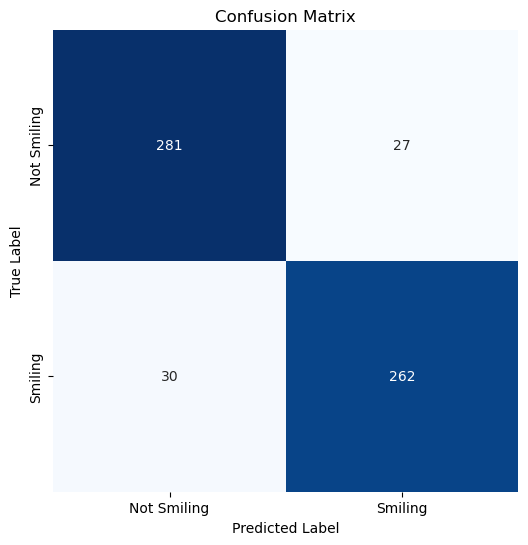

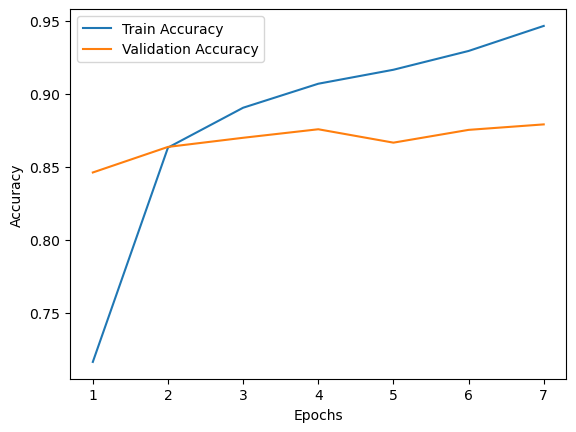

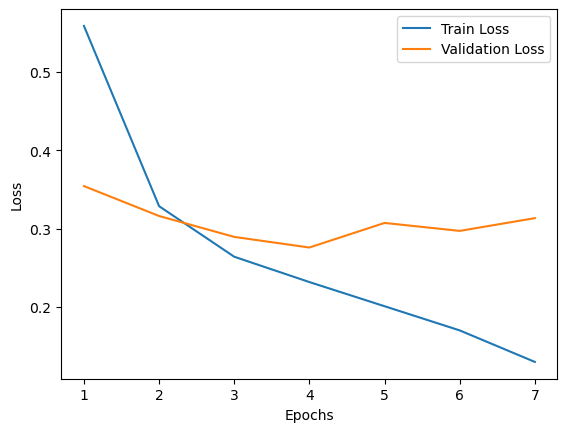

In [ ]:
#Basic CNN model
model_pipeline(labeled_images_df.collect(), create_basic_cnn_model)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

Epoch 1/20
    110/Unknown 24s 190ms/step - accuracy: 0.5901 - loss: 0.6581

c:\Users\cybrm\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.5910 - loss: 0.6572 - val_accuracy: 0.8492 - val_loss: 0.3389 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 238ms/step - accuracy: 0.8655 - loss: 0.3147 - val_accuracy: 0.8587 - val_loss: 0.3126 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 235ms/step - accuracy: 0.8934 - loss: 0.2580 - val_accuracy: 0.8954 - val_loss: 0.2513 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - accuracy: 0.9110 - loss: 0.2185 - val_accuracy: 0.8888 - val_loss: 0.2609 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9198 - loss: 0.1921
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 238ms/step - accuracy: 0.9198 - loss: 0.1921 - val_accuracy: 0.8958 - val_loss: 0.2538 - learning_rate: 0.0010
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - accuracy: 0.9329 - loss: 0

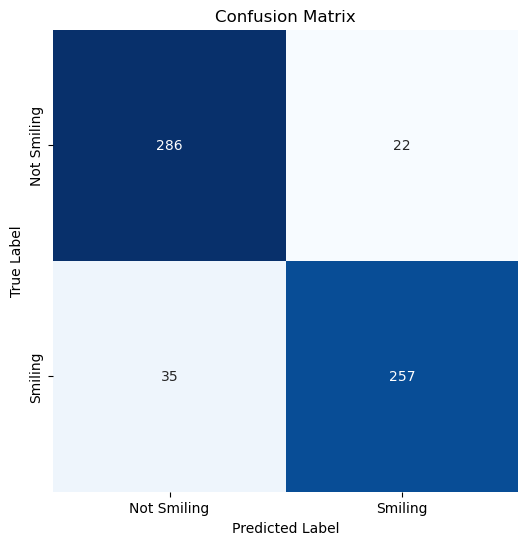

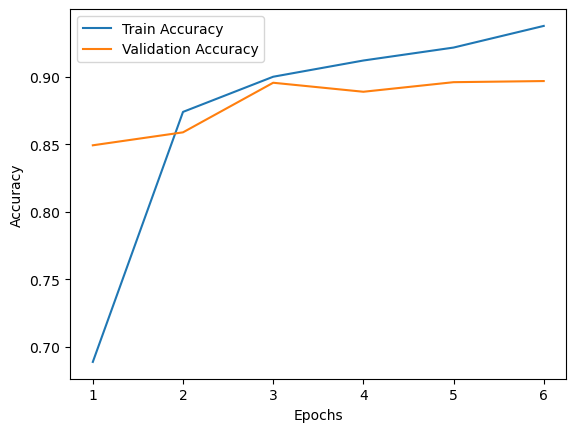

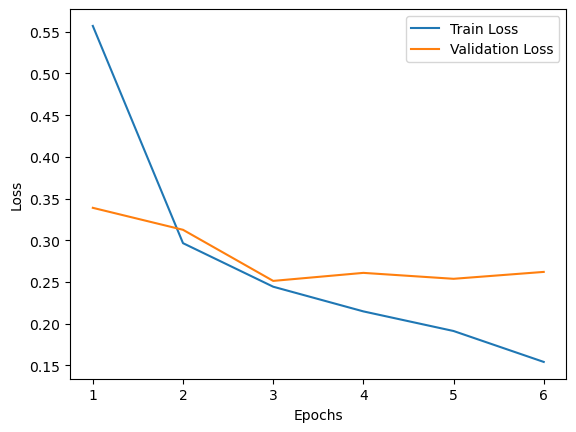

In [ ]:
#Simple CNN model
model_pipeline(labeled_images_df.collect(), create_simple_cnn_model)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

Epoch 1/20
    110/Unknown 26s 208ms/step - accuracy: 0.5781 - loss: 1.1496

c:\Users\cybrm\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


110/110 ━━━━━━━━━━━━━━━━━━━━ 31s 252ms/step - accuracy: 0.5788 - loss: 1.1471 - val_accuracy: 0.8146 - val_loss: 0.5621 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 252ms/step - accuracy: 0.8234 - loss: 0.5418 - val_accuracy: 0.8483 - val_loss: 0.4658 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 256ms/step - accuracy: 0.8602 - loss: 0.4520 - val_accuracy: 0.8633 - val_loss: 0.4158 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 252ms/step - accuracy: 0.8645 - loss: 0.4247 - val_accuracy: 0.8788 - val_loss: 0.3935 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 251ms/step - accuracy: 0.8789 - loss: 0.4049 - val_accuracy: 0.8863 - val_loss: 0.3752 - learning_rate: 0.0010
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - accuracy: 0.8893 - loss: 0.3836 - val_accuracy: 0.8404 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8802 - loss: 

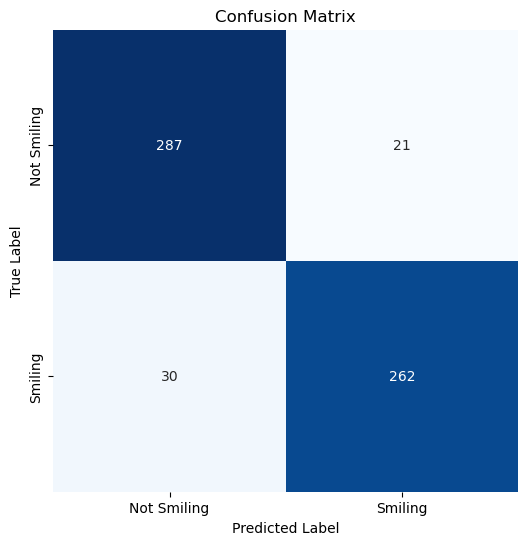

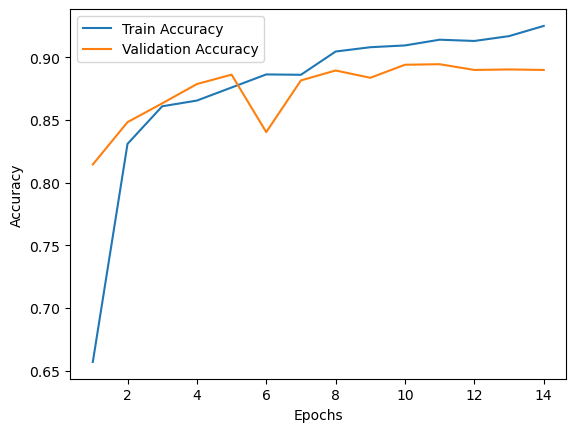

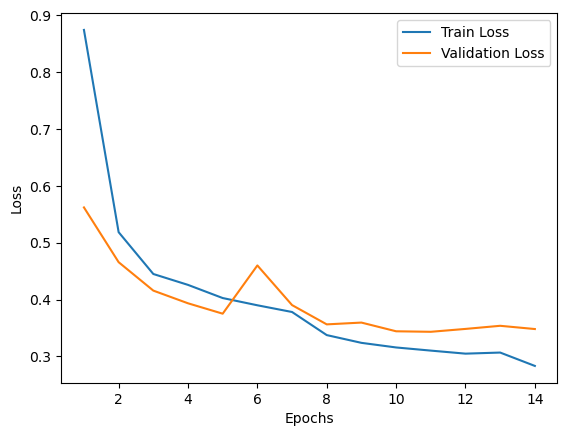

In [ ]:
#Simple CNN model with regularisation
model_pipeline(labeled_images_df.collect(), create_simple_cnn_model_with_regularisation)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

Epoch 1/20
    110/Unknown 25s 196ms/step - accuracy: 0.5066 - loss: 1.3081

c:\Users\cybrm\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - accuracy: 0.5067 - loss: 1.3054 - val_accuracy: 0.6067 - val_loss: 0.7646 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 258ms/step - accuracy: 0.5540 - loss: 0.7436 - val_accuracy: 0.7796 - val_loss: 0.5423 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 254ms/step - accuracy: 0.7768 - loss: 0.5504 - val_accuracy: 0.8404 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 256ms/step - accuracy: 0.8348 - loss: 0.4550 - val_accuracy: 0.8425 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 256ms/step - accuracy: 0.8525 - loss: 0.4329 - val_accuracy: 0.8646 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - accuracy: 0.8604 - loss: 0.4030 - val_accuracy: 0.8792 - val_loss: 0.3572 - learning_rate: 0.0010
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 260ms/step - accuracy: 0.8810 - loss:

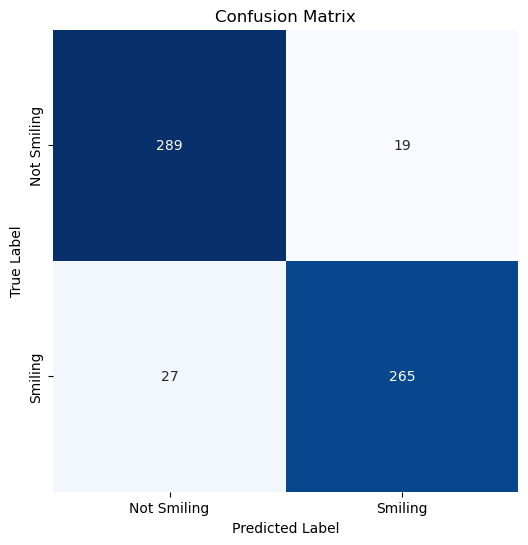

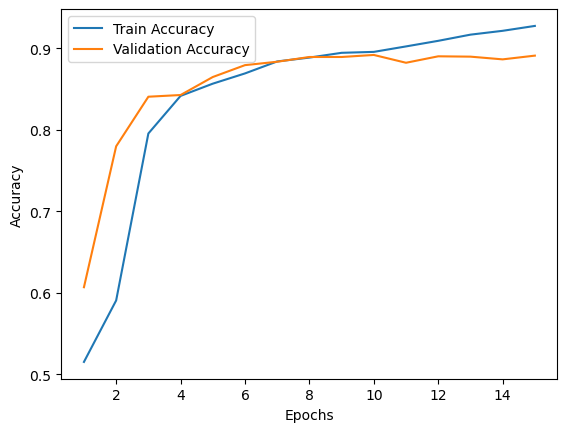

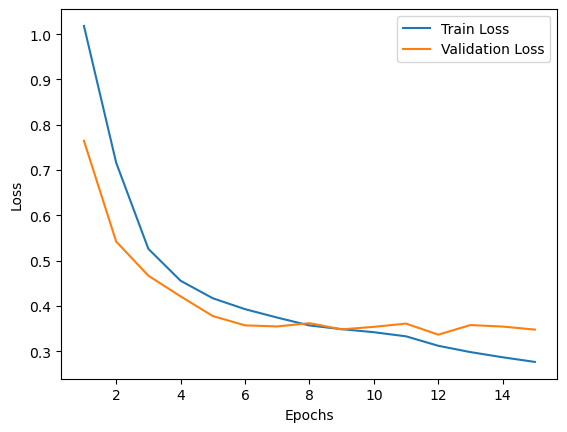

In [ ]:
#Double CNN layered model with regularisation
model_pipeline(labeled_images_df.collect(), create_duel_layered_cnn_model_with_regularisation)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

In [ ]:
###############################################################################################################################################################
#----------------------------------------------------------------------ADDITIONAL MODELS-----------------------------------------------------------------------
###############################################################################################################################################################

In [65]:
###############################################################################################################################################################
#----------------------------------------------------------------------USER INPUT------------------------------------------------------------------------------
###############################################################################################################################################################